# Educational Reading Level Classification

## Import Libraries

Install and import any required Python packages and libraries.

In [ ]:
pip install -r requirements.txt

In [ ]:
import os
import torch
import random
import numpy as np
import pandas as pd
from typing import Tuple
from pathlib import Path
from datasets import Dataset
import matplotlib.pyplot as plt
import datasets, evaluate, accelerate
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, EarlyStoppingCallback, Trainer
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification

## Load Data

Load custom datasets:
- **fiction**: used for training, validation, and testing
- **nonfiction**: used for testing out-of-domain generalization

In [ ]:
# Load fiction and nonfiction data
all_fiction_data = pd.read_csv("data/fiction.csv")
all_nonfiction_data = pd.read_csv("data/nonfiction.csv")

In [ ]:
# Shuffle data randomly
all_fiction_data = all_fiction_data.sample(frac=1)
all_nonfiction_data = all_nonfiction_data.sample(frac=1)

## Clean Data

Here, we rename columns and fix small formatting issues (i.e. trailing whitespace) to maintain consistency.

In [ ]:
# Rename columns for consistency
all_fiction_data = all_fiction_data.rename(columns={"passage": "text",
                                                    "reading_level": "labels"})
all_nonfiction_data = all_nonfiction_data.rename(columns={"passage": "text",
                                                          "reading_level": "labels"})

In [ ]:
# Check unique classes
all_fiction_data['labels'].unique()

array(['Elementary', 'Middle', 'High', 'High ', 'Middle '], dtype=object)

In [ ]:
# Combine classes that are the same
map_levels = {
    'Middle ': 'Middle',
    'High ': 'High'
}

all_fiction_data['labels'] = all_fiction_data['labels'].replace(map_levels)
all_nonfiction_data['labels'] = all_nonfiction_data['labels'].replace(map_levels)

After cleaning, we output the distribution of target classes to confirm that the fiction dataset is roughly balanced across reading levels.

In [ ]:
# Check amount of data in each class
all_fiction_data['labels'].value_counts()

,count
labels,
Middle,1746
High,1741
Elementary,1661


We convert each dataset into a Hugging Face ``Dataset`` object.

In [ ]:
# Convert to Hugging Face Dataset
all_fiction_data = Dataset.from_pandas(all_fiction_data)
all_nonfiction_data = Dataset.from_pandas(all_nonfiction_data)

## Prepare Data for Classification

In [ ]:
id2label = {0: "Elementary", 1: "Middle", 2: "High"}
label2id = {"Elementary": 0, "Middle": 1, "High": 2}

We map all labels into numerical classes (Elementary (0), Middle (1), High (2)) using a fixed mapping.

In [ ]:
# Turn labels into 0, 1, or 2
def map_labels_to_number(example):
  example["labels"] = label2id[example["labels"]]
  return example

fiction_data = all_fiction_data.map(map_labels_to_number)
nonfiction_data = all_nonfiction_data.map(map_labels_to_number)

Map:   0%|          | 0/5148 [00:00<?, ? examples/s]

Map:   0%|          | 0/2086 [00:00<?, ? examples/s]

Split the fiction dataset into training (70%), validation (15%), test (15%) sets.

In [ ]:
# Split fiction into train + temp
temp_split = fiction_data.train_test_split(test_size=0.3)

# Split temp into validation + test
val_test = temp_split["test"].train_test_split(test_size=0.5, seed=42)

fiction_data = {
    "train": temp_split["train"],
    "validation": val_test["train"],
    "test": val_test["test"]
}

In [ ]:
# View the dataset splits
fiction_data

{'train': Dataset({
     features: ['text', 'labels', '__index_level_0__'],
     num_rows: 3603
 }),
 'validation': Dataset({
     features: ['text', 'labels', '__index_level_0__'],
     num_rows: 772
 }),
 'test': Dataset({
     features: ['text', 'labels', '__index_level_0__'],
     num_rows: 773
 })}

## Prepare Tokenizers

We load the pretrained tokenizers that match each transformer architecture.
The text is truncated/padded to a fixed length of **256 tokens**.

In [ ]:
roberta_tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="roberta-large",
                                                  use_fast=True)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
distilbert_tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
                                                     use_fast=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
xlnet_tokenizer = XLNetTokenizer.from_pretrained(pretrained_model_name_or_path="xlnet-base-cased",
                                                 use_fast=True)

spiece.model:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

In [ ]:
ernie_tokenizer = BertTokenizer.from_pretrained(pretrained_model_name_or_path="nghuyong/ernie-2.0-en",
                                                use_fast=True)

tokenizer_config.json:   0%|          | 0.00/62.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/464 [00:00<?, ?B/s]

In [ ]:
def tokenize(examples, tokenizer):
    return tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=256
    )

## Prepare Tokenized Datasets

With the tokenizers ready, we apply them to each split of the fiction dataset (train, validation, test) for each of the models.

In [ ]:
roberta_train_tokenized = fiction_data["train"].map(
    lambda x: tokenize(x, roberta_tokenizer),
    batched=True
)

roberta_val_tokenized = fiction_data["validation"].map(
    lambda x: tokenize(x, roberta_tokenizer),
    batched=True
)
roberta_test_tokenized = fiction_data["test"].map(
    lambda x: tokenize(x, roberta_tokenizer),
    batched=True
)

Map:   0%|          | 0/3603 [00:00<?, ? examples/s]

Map:   0%|          | 0/772 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

In [ ]:
distilbert_train_tokenized = fiction_data["train"].map(
    lambda x: tokenize(x, distilbert_tokenizer),
    batched=True
)
distilbert_val_tokenized = fiction_data["validation"].map(
    lambda x: tokenize(x, distilbert_tokenizer),
    batched=True
)
distilbert_test_tokenized = fiction_data["test"].map(
    lambda x: tokenize(x, distilbert_tokenizer),
    batched=True
)

Map:   0%|          | 0/3603 [00:00<?, ? examples/s]

Map:   0%|          | 0/772 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

In [ ]:
xlnet_train_tokenized = fiction_data["train"].map(
    lambda x: tokenize(x, xlnet_tokenizer),
    batched=True
)
xlnet_val_tokenized = fiction_data["validation"].map(
    lambda x: tokenize(x, xlnet_tokenizer),
    batched=True
)
xlnet_test_tokenized = fiction_data["test"].map(
    lambda x: tokenize(x, xlnet_tokenizer),
    batched=True
)

Map:   0%|          | 0/3603 [00:00<?, ? examples/s]

Map:   0%|          | 0/772 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

In [ ]:
ernie_train_tokenized = fiction_data["train"].map(
    lambda x: tokenize(x, ernie_tokenizer),
    batched=True
)
ernie_val_tokenized = fiction_data["validation"].map(
    lambda x: tokenize(x, ernie_tokenizer),
    batched=True
)
ernie_test_tokenized = fiction_data["test"].map(
    lambda x: tokenize(x, ernie_tokenizer),
    batched=True
)

Map:   0%|          | 0/3603 [00:00<?, ? examples/s]

Map:   0%|          | 0/772 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

## Set Up Evaluation Metric

To measure how well each model performs, we load an accuracy functions from the ``evaluate`` library.

In [ ]:
accuracy_metric = evaluate.load("accuracy")

def compute_accuracy(predictions_and_labels: Tuple[np.array, np.array]):
  """
  Computes the accuracy of a model by comparing the predictions and labels.
  """
  predictions, labels = predictions_and_labels

  # Get highest prediction probability of each prediction if predictions are probabilities
  if len(predictions.shape) >= 2:
    predictions = np.argmax(predictions, axis=1)

  return accuracy_metric.compute(predictions=predictions, references=labels)

## Set Up Models for Training

We fine-tune four different pretrained transformer models: RoBERTa-large, DistilBERT, XLNet-base, and ERNIE 2.0.

These models will all be trained on the same dataset so we can compare their performance using accuracy and loss on the reading-level classification task.

In [ ]:
roberta_model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="roberta-large",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
distilbert_model = AutoModelForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="distilbert/distilbert-base-uncased",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
xlnet_model = XLNetForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="xlnet-base-cased",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

pytorch_model.bin:   0%|          | 0.00/467M [00:00<?, ?B/s]

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
ernie_model = BertForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path="nghuyong/ernie-2.0-en",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

You are using a model of type ernie to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nghuyong/ernie-2.0-en and are newly initialized: ['bert.embeddings.LayerNorm.bias', 'bert.embeddings.LayerNorm.weight', 'bert.embeddings.position_embeddings.weight', 'bert.embeddings.token_type_embeddings.weight', 'bert.embeddings.word_embeddings.weight', 'bert.encoder.layer.0.attention.output.LayerNorm.bias', 'bert.encoder.layer.0.attention.output.LayerNorm.weight', 'bert.encoder.layer.0.attention.output.dense.bias', 'bert.encoder.layer.0.attention.output.dense.weight', 'bert.encoder.layer.0.attention.self.key.bias', 'bert.encoder.layer.0.attention.self.key.weight', 'bert.encoder.layer.0.attention.self.query.bias', 'bert.encoder.layer.0.attention.self.query.weight', 'bert.encoder.layer.0.attention.self.value.bias', 'bert.encoder.layer.0.attention.self.value.weight', 'bert.encoder.layer.0.intermediate.dense.bias', 'bert.encoder.layer.0.intermediate.dense.weight', 'bert.encoder.layer.0.output

To understand each model's capacity, we output the total number of parameters and number of trainable parameters.

In [ ]:
# Count # parameters of the model
def count_params(model):
    """
    Count the parameters of a PyTorch model.
    """
    trainable_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total_parameters = sum(p.numel() for p in model.parameters())

    print({"trainable_parameters": trainable_parameters, "total_parameters": total_parameters})

In [ ]:
count_params(roberta_model)
count_params(distilbert_model)
count_params(xlnet_model)
count_params(ernie_model)

{'trainable_parameters': 355362819, 'total_parameters': 355362819}
{'trainable_parameters': 66955779, 'total_parameters': 66955779}
{'trainable_parameters': 117311235, 'total_parameters': 117311235}
{'trainable_parameters': 109486083, 'total_parameters': 109486083}


All the parameters in all the models are trainable!

## Create Directory for Saving Models

We create a dedicated ``models`` directory to store the checkpoints generated during fine-tuning (each transformer model has its own subdirectory so the outputs stay organized).

In [ ]:
# Create models directory
models_dir = Path("models")
models_dir.mkdir(exist_ok=True)

# Create model save paths
roberta_save_dir = Path(models_dir, "reading_level_text_classifier-roberta-large")
distilbert_save_dir = Path(models_dir, "reading_level_text_classifier-distilbert")
xlnet_save_dir = Path(models_dir, "reading_level_text_classifier-xlnet")
ernie_save_dir = Path(models_dir, "reading_level_text_classifier-ernie")

## Set Up Training Arguments

We define the training configuration used by all models with the ``Trainer`` API.
These shared settings allow us to train each model under the same conditions.

In [ ]:
model_dirs = [roberta_save_dir,
              distilbert_save_dir,
              xlnet_save_dir,
              ernie_save_dir]

for model_dir in model_dirs:
    print(f"[INFO] Saving model checkpoints to: {model_dir}")

    # Create training arguments
    training_args = TrainingArguments(
        output_dir=model_dir,

        learning_rate=1e-5,
        weight_decay=0.05,
        warmup_ratio=0.1,

        per_device_train_batch_size=4,
        per_device_eval_batch_size=4,
        gradient_accumulation_steps=1,
        num_train_epochs=5,

        fp16=True,

        eval_strategy="epoch",
        save_strategy="epoch",
        save_total_limit=3,
        load_best_model_at_end=True,

        no_cuda=False,

        logging_strategy="epoch",
        report_to="none",

        hub_private_repo=False,
    )

[INFO] Saving model checkpoints to: models/reading_level_text_classifier-roberta-large
[INFO] Saving model checkpoints to: models/reading_level_text_classifier-distilbert
[INFO] Saving model checkpoints to: models/reading_level_text_classifier-xlnet
[INFO] Saving model checkpoints to: models/reading_level_text_classifier-ernie


## Set Up Trainer Instances

For each model, we create a ``Trainer`` object from the Hugging Face Transformers library.

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
roberta_trainer = Trainer(
    model=roberta_model,
    args=training_args,
    train_dataset=roberta_train_tokenized,
    eval_dataset=roberta_val_tokenized,
    tokenizer=roberta_tokenizer,
    compute_metrics=compute_accuracy
)

/tmp/ipython-input-2220557998.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  roberta_trainer = Trainer(


In [ ]:
distilbert_trainer = Trainer(
    model=distilbert_model,
    args=training_args,
    train_dataset=distilbert_train_tokenized,
    eval_dataset=distilbert_val_tokenized,
    tokenizer=distilbert_tokenizer,
    compute_metrics=compute_accuracy
)

/tmp/ipython-input-1885591994.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  distilbert_trainer = Trainer(


In [ ]:
xlnet_trainer = Trainer(
    model=xlnet_model,
    args=training_args,
    train_dataset=xlnet_train_tokenized,
    eval_dataset=xlnet_val_tokenized,
    tokenizer=xlnet_tokenizer,
    compute_metrics=compute_accuracy
)

/tmp/ipython-input-1088928813.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  xlnet_trainer = Trainer(


In [ ]:
ernie_trainer = Trainer(
    model=ernie_model,
    args=training_args,
    train_dataset=ernie_train_tokenized,
    eval_dataset=ernie_val_tokenized,
    tokenizer=ernie_tokenizer,
    compute_metrics=compute_accuracy
)

/tmp/ipython-input-1806178208.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  ernie_trainer = Trainer(


## Training Text Classification Model

We train each model using the Hugging Face ``Trainer`` API.
We report the training loss, validation loss, and validation accuracy at the end of each epoch.

In [ ]:
roberta_results = roberta_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.911900,0.595349,0.762953
2,0.571700,0.832248,0.775907
3,0.403300,1.032337,0.839378
4,0.217100,0.962878,0.856218
5,0.095300,1.033762,0.858808


In [ ]:
distilbert_results = distilbert_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.922700,0.654597,0.721503
2,0.545800,0.518512,0.783679
3,0.340500,0.747370,0.808290
4,0.214200,0.872635,0.814767
5,0.134200,0.908937,0.808290


In [ ]:
xlnet_results = xlnet_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.934500,0.664583,0.693005
2,0.616400,0.523304,0.788860
3,0.410100,0.764510,0.819948
4,0.271600,0.969591,0.826425
5,0.156900,1.056610,0.832902


In [ ]:
ernie_results = ernie_trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.066400,1.035091,0.474093
2,0.962400,0.947286,0.488342
3,0.899300,0.864091,0.581606
4,0.794800,0.886771,0.591969
5,0.707500,0.890509,0.594560


## Save Models for Later Use

We save each model’s best checkpoint to its designated folder after training.

In [ ]:
roberta_trainer.save_model(output_dir=roberta_save_dir)
distilbert_trainer.save_model(output_dir=distilbert_save_dir)
xlnet_trainer.save_model(output_dir=xlnet_save_dir)
ernie_trainer.save_model(output_dir=ernie_save_dir)

## Inspect Model Training Metrics

We extract the training logs recorded by the ``Trainer`` to better understand how each model learned over time.

We also visualize the training and validation loss curves for each model to check for overfitting and understand model learning.

RoBERTa Training and Evaluation Metrics:


,loss,grad_norm,learning_rate,epoch,step
0,0.9119,88.631897,8.892452e-06,1.0,901
1,0.5717,135.763718,6.669956e-06,2.0,1802
2,0.4033,12.316146,4.447459e-06,3.0,2703
3,0.2171,541.617737,2.224963e-06,4.0,3604
4,0.0953,0.005448,2.466700e-09,5.0,4505


,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,0.595349,0.762953,9.4539,81.659,20.415,1.0,901
1,0.832248,0.775907,9.2375,83.573,20.893,2.0,1802
2,1.032337,0.839378,9.2136,83.789,20.947,3.0,2703
3,0.962878,0.856218,9.2151,83.775,20.944,4.0,3604
4,1.033762,0.858808,9.2263,83.674,20.918,5.0,4505



 ********** 




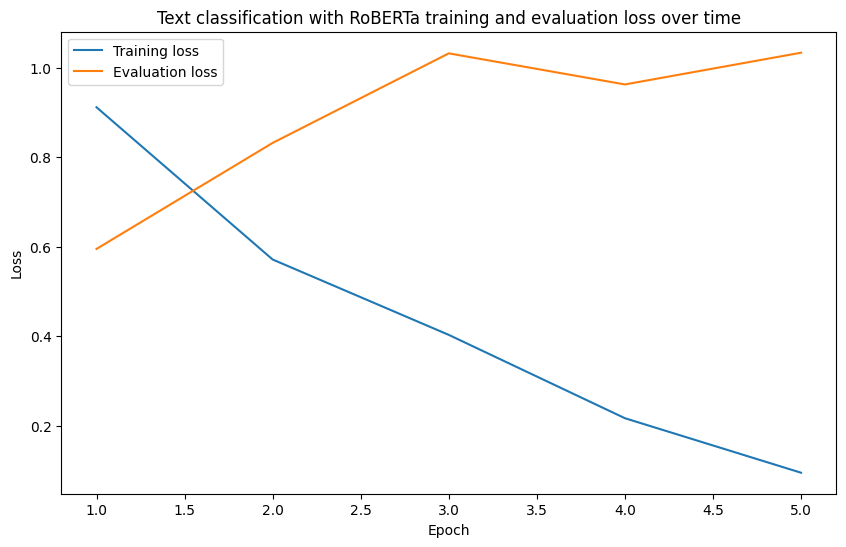

DistilBERT Training and Evaluation Metrics:


,loss,grad_norm,learning_rate,epoch,step
0,0.9227,21.716282,8.892452e-06,1.0,901
1,0.5458,24.956007,6.669956e-06,2.0,1802
2,0.3405,2.210716,4.447459e-06,3.0,2703
3,0.2142,66.638115,2.224963e-06,4.0,3604
4,0.1342,2.647926,2.466700e-09,5.0,4505


,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,0.654597,0.721503,2.1802,354.103,88.526,1.0,901
1,0.518512,0.783679,1.9422,397.477,99.369,2.0,1802
2,0.747370,0.808290,1.9976,386.455,96.614,3.0,2703
3,0.872635,0.814767,1.9409,397.761,99.440,4.0,3604
4,0.908937,0.808290,2.2269,346.671,86.668,5.0,4505



 ********** 




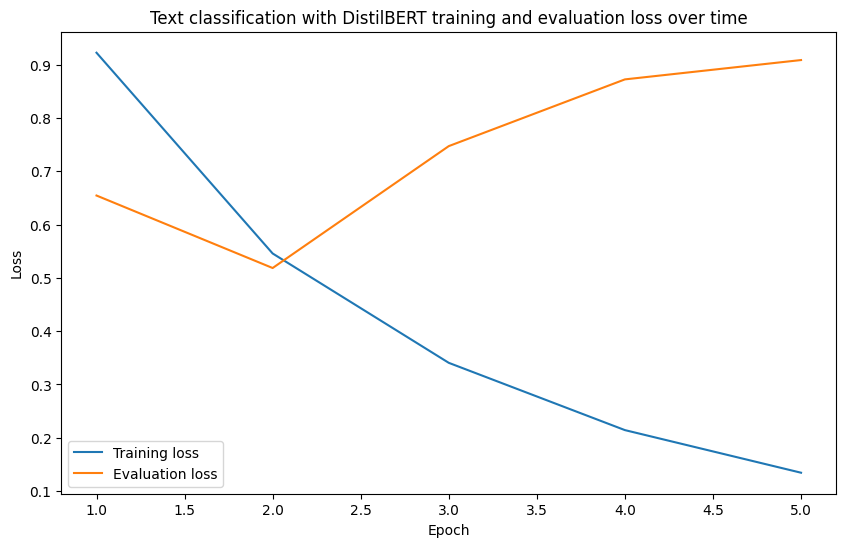

XLNet Training and Evaluation Metrics:


,loss,grad_norm,learning_rate,epoch,step
0,0.9345,23.614073,8.892452e-06,1.0,901
1,0.6164,24.368530,6.669956e-06,2.0,1802
2,0.4101,125.352409,4.447459e-06,3.0,2703
3,0.2716,0.372877,2.224963e-06,4.0,3604
4,0.1569,0.107599,2.466700e-09,5.0,4505


,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,0.664583,0.693005,7.1601,107.820,26.955,1.0,901
1,0.523304,0.788860,6.9258,111.468,27.867,2.0,1802
2,0.764510,0.819948,6.9694,110.770,27.692,3.0,2703
3,0.969591,0.826425,6.9773,110.645,27.661,4.0,3604
4,1.056610,0.832902,6.7495,114.379,28.595,5.0,4505



 ********** 




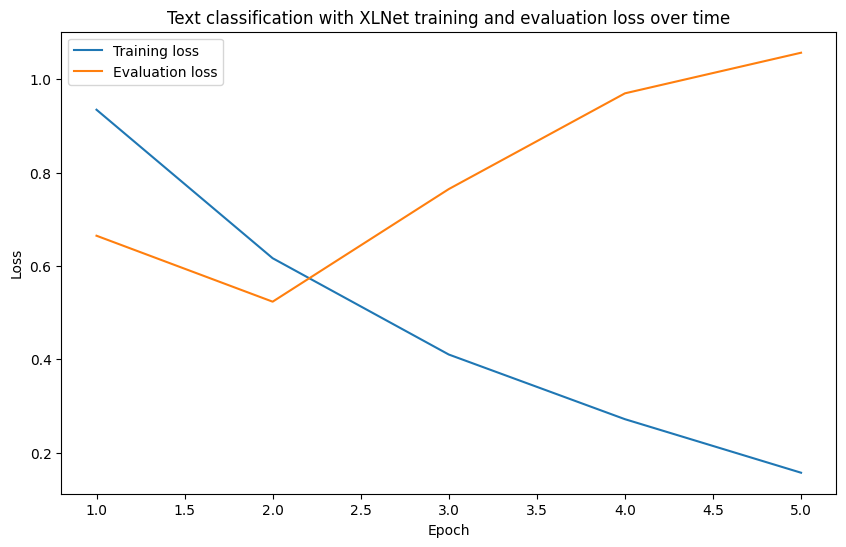

Ernie Training and Evaluation Metrics:


,loss,grad_norm,learning_rate,epoch,step
0,1.0664,5.841380,8.892452e-06,1.0,901
1,0.9624,24.133026,6.669956e-06,2.0,1802
2,0.8993,38.313179,4.447459e-06,3.0,2703
3,0.7948,132.652405,2.224963e-06,4.0,3604
4,0.7075,110.266266,2.466700e-09,5.0,4505


,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,1.035091,0.474093,3.5102,219.928,54.982,1.0,901
1,0.947286,0.488342,3.4935,220.985,55.246,2.0,1802
2,0.864091,0.581606,3.6517,211.411,52.853,3.0,2703
3,0.886771,0.591969,3.4890,221.264,55.316,4.0,3604
4,0.890509,0.594560,3.7058,208.324,52.081,5.0,4505



 ********** 




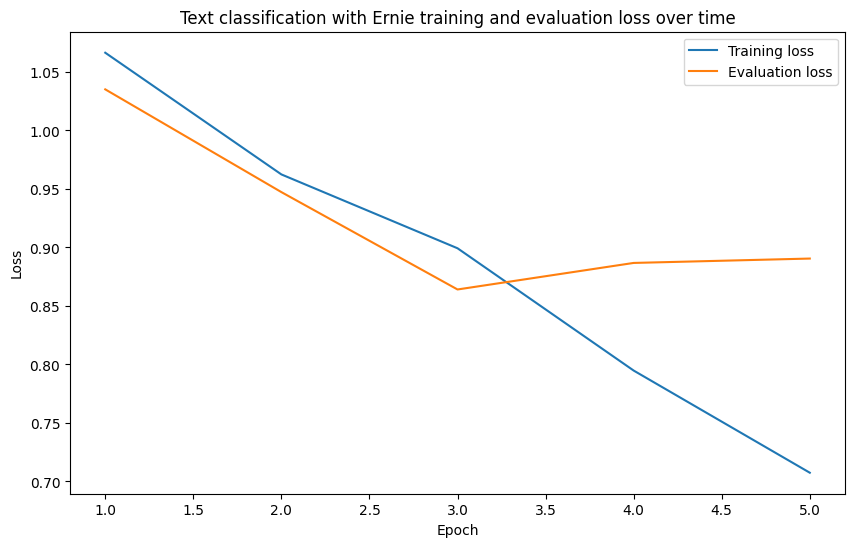

In [ ]:
trainers = [roberta_trainer, distilbert_trainer, xlnet_trainer, ernie_trainer]
models = ["RoBERTa", "DistilBERT", "XLNet", "Ernie"]
for trainer, model in zip(trainers, models):
    # Get training history
    trainer_history_all = trainer.state.log_history
    trainer_history_metrics = trainer_history_all[:-1]
    trainer_history_training_time = trainer_history_all[-1]

    # Extract training and evaluation metrics
    trainer_history_training_set = []
    trainer_history_eval_set = []

    # Loop through metrics and filter for training and eval metrics
    for item in trainer_history_metrics:
        item_keys = list(item.keys())
        # Check to see if "eval" is in the keys of the item
        if any("eval" in item for item in item_keys):
            trainer_history_eval_set.append(item)
        else:
            trainer_history_training_set.append(item)

    # Create pandas DataFrames for the training and evaluation metrics
    trainer_history_training_df = pd.DataFrame(trainer_history_training_set)
    trainer_history_eval_df = pd.DataFrame(trainer_history_eval_set)

    print(f"{model} Training and Evaluation Metrics:")
    display(trainer_history_training_df)
    display(trainer_history_eval_df)
    print("\n","*"*10, "\n\n")

    # Plot training and evaluation loss
    plt.figure(figsize=(10, 6))
    plt.plot(trainer_history_training_df["epoch"], trainer_history_training_df["loss"], label="Training loss")
    plt.plot(trainer_history_eval_df["epoch"], trainer_history_eval_df["eval_loss"], label="Evaluation loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Text classification with {model} training and evaluation loss over time")
    plt.legend()
    plt.show()

Across most models, epoch=2 seems to strike the best balance between training and evaluation loss. We will train our final model to 2 epochs.

DistilBERT and XLNet both have relatively low losses and high accuracies at epoch=2, while RoBERTa and ERNIE have higher losses and lower accuracies.

**For our final model, we decide to use DistilBERT** because it achieves the lowest loss at epoch=2.

## Create final model

Merge the original training and validation sets into a single, larger training dataset.

We follow and apply the same training pipeline to the DistilBERT model, but trained with 2 epochs.

(Due to an unknown issue, the model checkpoints generated inconsistently and didn't save to their respective subdirectories, so we retrained the model with the desired configurations.)

In [ ]:
from datasets import concatenate_datasets
all_train_data = concatenate_datasets([
    fiction_data["train"],
    fiction_data["validation"]
])
final_save_dir = Path(models_dir, "reading_level_text_classifier-final")

final_train_tokenized = all_train_data.map(
    lambda x: tokenize(x, distilbert_tokenizer),
    batched=True
)
final_test_tokenized = fiction_data["test"].map(
    lambda x: tokenize(x, distilbert_tokenizer),
    batched=True
)

Map:   0%|          | 0/4375 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

This time, we evaluate on the fiction test set, rather than the validation set.

In [ ]:
# Create training arguments
training_args = TrainingArguments(
    output_dir=final_save_dir,

    learning_rate=1e-5,
    weight_decay=0.05,
    warmup_ratio=0.1,

    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=1,
    num_train_epochs=2,

    fp16=True,

    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=3,
    load_best_model_at_end=True,

    no_cuda=False,

    logging_strategy="epoch",
    report_to="none",

    hub_private_repo=False,
)

final_trainer = Trainer(
    model=distilbert_model,
    args=training_args,
    train_dataset=final_train_tokenized,
    eval_dataset=final_test_tokenized,
    tokenizer=distilbert_tokenizer,
)

/tmp/ipython-input-389457151.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  final_trainer = Trainer(


In [ ]:
final_trainer.train()

Epoch,Training Loss,Validation Loss
1,0.397400,0.670804
2,0.228400,0.842582


TrainOutput(global_step=2188, training_loss=0.3129273716230933, metrics={'train_runtime': 131.2855, 'train_samples_per_second': 66.649, 'train_steps_per_second': 16.666, 'total_flos': 579555204480000.0, 'train_loss': 0.3129273716230933, 'epoch': 2.0})

DistilBERT Training and Evaluation Metrics:


,loss,grad_norm,learning_rate,epoch,step
0,0.3974,27.033928,5.561199e-06,1.0,1094
1,0.2284,166.565384,5.078720e-09,2.0,2188


,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,0.670804,1.9351,399.467,100.254,1.0,1094
1,0.842582,1.8663,414.183,103.948,2.0,2188



 ********** 




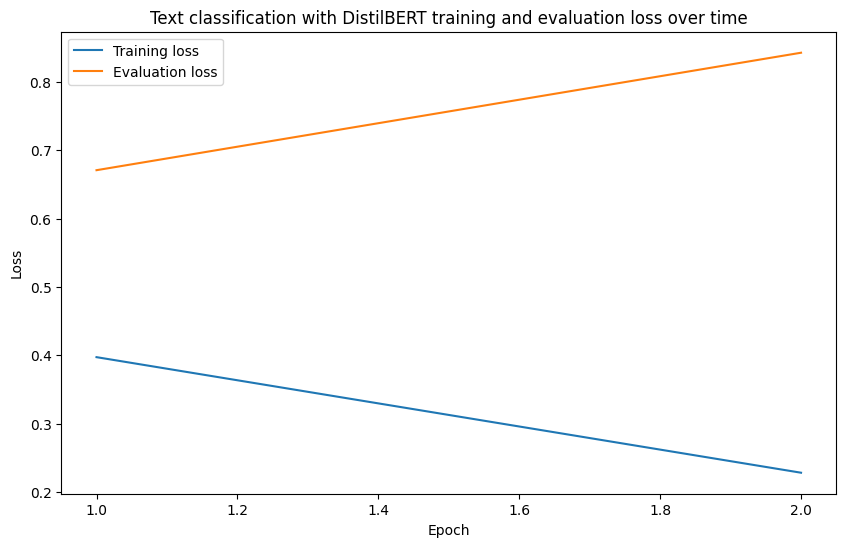

In [ ]:
 # Get training history
trainer_history_all = final_trainer.state.log_history
trainer_history_metrics = trainer_history_all[:-1]
trainer_history_training_time = trainer_history_all[-1]

# Extract training and evaluation metrics
trainer_history_training_set = []
trainer_history_eval_set = []

# Loop through metrics and filter for training and eval metrics
for item in trainer_history_metrics:
    item_keys = list(item.keys())
    # Check to see if "eval" is in the keys of the item
    if any("eval" in item for item in item_keys):
        trainer_history_eval_set.append(item)
    else:
        trainer_history_training_set.append(item)

# Create pandas DataFrames for the training and evaluation metrics
trainer_history_training_df = pd.DataFrame(trainer_history_training_set)
trainer_history_eval_df = pd.DataFrame(trainer_history_eval_set)

print(f"DistilBERT Training and Evaluation Metrics:")
display(trainer_history_training_df)
display(trainer_history_eval_df)
print("\n","*"*10, "\n\n")

# Plot training and evaluation loss
plt.figure(figsize=(10, 6))
plt.plot(trainer_history_training_df["epoch"], trainer_history_training_df["loss"], label="Training loss")
plt.plot(trainer_history_eval_df["epoch"], trainer_history_eval_df["eval_loss"], label="Evaluation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Text classification with DistilBERT training and evaluation loss over time")
plt.legend()
plt.show()

## Test Final Model on OOD

To evaluate how well the final DistilBERT model generalizes beyond the fiction passages it was trained on, we test it on a separate nonfiction dataset.
We follow and apply the same process of tokenization to this dataset and run the evaluation.

In [ ]:
nonfiction_tokenized = nonfiction_data.map(
    lambda x: tokenize(x, distilbert_tokenizer),
    batched=True
)

Map:   0%|          | 0/2086 [00:00<?, ? examples/s]

In [ ]:
final_trainer.evaluate(nonfiction_tokenized)

{'eval_loss': 1.7701399326324463,
 'eval_runtime': 5.082,
 'eval_samples_per_second': 410.472,
 'eval_steps_per_second': 102.716,
 'epoch': 2.0}

The above results suggest that the model struggles more with nonfiction texts, highlighting that reading level learned from fiction texts do not fully transfer to other genres.

## Model Evaluation on Test Set (In-Domain)

We compute a set of classification metrics on the held-out fiction test set: precision, recall, F1-score, accuracy, and Matthews Correlation Coefficient (MCC)

In [ ]:
id_pred_output = final_trainer.predict(final_test_tokenized)
id_pred_logits = id_pred_output.predictions
id_pred_labels = id_pred_logits.argmax(axis=-1)
id_true_labels = final_test_tokenized["labels"]

id_misclassified_idx = np.where(id_pred_labels != id_true_labels)[0]

id_misclassified_samples = []

for idx in id_misclassified_idx:
    idx = int(idx)
    id_misclassified_samples.append({
        "text": final_test_tokenized[idx]["text"],
        "true_label": id_true_labels[idx],
        "pred_label": id_pred_labels[idx]
    })

In [ ]:
id_metric = evaluate.load("mdocekal/precision_recall_fscore_accuracy", average="weighted")
id_metric2 = evaluate.load("Yeshwant123/mcc")
metric_dict1 = id_metric.compute(predictions=id_pred_labels, references=id_true_labels)
metric_dict2 = id_metric2.compute(predictions=id_pred_labels, references=id_true_labels)
metric_dict1 | metric_dict2

{'precision': 0.8150848103337991,
 'recall': 0.815006468305304,
 'fscore': 0.8149907812237063,
 'accuracy': 0.815006468305304,
 'mcc': np.float64(0.7222001598168237)}

The in-domain results show strong performance.

## Model Evaluation on Nonfiction Dataset (Out-of-Domain)

To understand how well the final model generalizes beyond fiction, we examine its performance on the nonfiction dataset. We compute the same set of classification metrics.

In [ ]:
ood_pred_output = final_trainer.predict(nonfiction_tokenized)
ood_pred_logits = ood_pred_output.predictions
ood_pred_labels = ood_pred_logits.argmax(axis=-1)
ood_true_labels = nonfiction_tokenized["labels"]

ood_misclassified_idx = np.where(ood_pred_labels != ood_true_labels)[0]

ood_misclassified_samples = []

for idx in ood_misclassified_idx:
    idx = int(idx)
    ood_misclassified_samples.append({
        "text": nonfiction_tokenized[idx]["text"],
        "true_label": ood_true_labels[idx],
        "pred_label": ood_pred_labels[idx]
    })

In [ ]:
ood_metric = evaluate.load("mdocekal/precision_recall_fscore_accuracy", average="weighted")
ood_metric2 = evaluate.load("Yeshwant123/mcc")
metric_dict1 = ood_metric.compute(predictions=ood_pred_labels, references=ood_true_labels)
metric_dict2 = ood_metric2.compute(predictions=ood_pred_labels, references=ood_true_labels)
metric_dict1 | metric_dict2

{'precision': 0.5869947319932404,
 'recall': 0.574784276126558,
 'fscore': 0.576514874927508,
 'accuracy': 0.574784276126558,
 'mcc': np.float64(0.362573967172647)}

These results show a clear decline compared to the fiction test set.

The drop indicates that the model struggles to transfer the reading-level patterns it learned from fictional texts to nonfiction writing.